In [1]:
import wfdb
import pandas as pd
import matplotlib.pyplot as plt
import statistics
import numpy as np
import math
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
from numpy.random import permutation
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split

In [2]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [3]:
def calcola_NN50_v1(rr_list):
    NN50_v1_count=0
    for i in range(0,len(rr_list)-1): 
        if(abs(rr_list[i]-rr_list[i+1])-0.050>=0):
            NN50_v1_count+=1
    return NN50_v1_count

In [4]:
def calcola_NN50_v2(list):
    NN50_v2_count=0
    for i in range(1,len(list)):
        if(abs(list[i]-list[i-1])-0.050>=0):
            NN50_v2_count+=1
    return NN50_v2_count

In [5]:
def serial_corr(y1, lag=1):
    y2=np.roll(y1,lag)
    m=statistics.mean(y1)
    num=0
    denom=0
#    print(np.corrcoef(y1,y2)[0,1])
    for i in range(0,len(y1)):
        num+=(y1[i]-m)*(y2[i]-m)
        denom+=(y1[i]-m)**2
    return num/denom

In [6]:
def calcola_NEP(lista):
    sommatoria=0
    if(len(lista)<=2):
        return(np.nan)
    for i in range(1,len(lista)-1):
        var=(lista[i]-lista[i-1])*(lista[i+1]-lista[i])
        sommatoria+=(1-np.heaviside(var,0.5))
    return sommatoria/(len(lista)-2)

In [7]:
fileName=['a01','a02','a03','a04','a05','a06','a07','a08','a09','a10','a11','a12','a13','a14','a15','a16','a17','a18','a19','a20',
         'b01','b02','b03','b04','b05','c01','c02','c03','c04','c05','c06','c07','c08','c09','c10',
         'x01','x02','x03','x04','x05','x06','x07','x08','x09','x10','x11','x12','x13','x14','x15','x16','x17','x18','x19','x20']
mypath='C:/Users/sara/Documents/5anno/TESI/DataBase_PhysioNet/www.physionet.org/physiobank/database/apnea-ecg/'


In [21]:
df_features_list=[]
for index in range(0,34):
#index=0
    recordname=mypath+fileName[index]
    print(index)

    #leggo RR da csv
    dfQRS = pd.read_pickle( mypath+'RR-EDR/'+fileName[index]+'RR.pkl')
    RR_intervals=dfQRS['rr']

    df = pd.read_pickle( mypath+'DivisioneDB/'+fileName[index]+'divisione.pkl')

    # calcolo interbeat differentials rd[i]=rr[i+1]−rr[i]
    rd_intervals=[]
    rd_intervals_2=[]
    for i in range(0,len(RR_intervals)-1):
        rd_intervals.append(RR_intervals[i+1]-RR_intervals[i])
    rd_intervals_2=np.power(rd_intervals,2)

    #label
    label=[]
    for i in range(0,len(df['label'])):
        if(df['label'][i]=='N'):
            label.append(0)
        else:
            label.append(1)


    #CALCOLO LE FEATURES
    df_features=pd.DataFrame()
    mediaRR=[]
    stdRR=[]
    durata=[]
    db=[]
    for i in range(0,len(df)):
        durata.append(df['stopRRIndex'][i]-df['startRRIndex'][i])
        if(durata[i]<2):
            mediaRR.append(np.nan)
            stdRR.append(np.nan)
        else:
            intervalloRR=np.array(RR_intervals[df['startRRIndex'][i]:df['stopRRIndex'][i]])
            mediaRR.append(statistics.mean(intervalloRR))
            stdRR.append(statistics.stdev(intervalloRR))

        db.append(index)

    df_features['db']=db
    df_features['mediaRR']=mediaRR
    df_features['stdRR']=stdRR
   # if(len(label)==len(NEP)+1):
     #   label=label[:-1]
    df_features['label']=label
    df_features=df_features.dropna() 
    df_features_list.append(df_features)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33


In [22]:
df_tot=pd.DataFrame()
for i in range(0,len(df_features_list)):
    df_tot=df_tot.append(df_features_list[i],ignore_index=True)

In [11]:
df_tot.to_pickle(mypath+'Features/FeaturesHRVTime.pkl')

In [23]:
len(df_tot)

16539

In [24]:
df_tot.columns

Index(['db', 'mediaRR', 'stdRR', 'label'], dtype='object')

In [27]:
df_normalized=pd.DataFrame()
df_normalized['db']=df_tot['db']
df_normalized['mediaRR']=preprocessing.normalize([np.array(df_tot['mediaRR'])])[0]
df_normalized['stdRR']=preprocessing.normalize([np.array(df_tot['stdRR'])])[0]
'''df_normalized['NN50_v1']=preprocessing.normalize([np.array(df_tot['NN50_v1'])])[0]
df_normalized['NN50_v2']=preprocessing.normalize([np.array(df_tot['NN50_v2'])])[0]
df_normalized['pNN50_v1']=preprocessing.normalize([np.array(df_tot['pNN50_v1'])])[0]
df_normalized['pNN50_v2']=preprocessing.normalize([np.array(df_tot['pNN50_v2'])])[0]
df_normalized['mean_rd']=preprocessing.normalize([np.array(df_tot['mean_rd'])])[0]
df_normalized['std_rd']=preprocessing.normalize([np.array(df_tot['std_rd'])])[0]
df_normalized['RMSDD']=preprocessing.normalize([np.array(df_tot['RMSDD'])])[0]
df_normalized['serialCC_1']=preprocessing.normalize([np.array(df_tot['serialCC_1'])])[0]
df_normalized['serialCC_2']=preprocessing.normalize([np.array(df_tot['serialCC_2'])])[0]
df_normalized['serialCC_3']=preprocessing.normalize([np.array(df_tot['serialCC_3'])])[0]
df_normalized['serialCC_4']=preprocessing.normalize([np.array(df_tot['serialCC_4'])])[0]
df_normalized['serialCC_5']=preprocessing.normalize([np.array(df_tot['serialCC_5'])])[0]
df_normalized['NEP']=preprocessing.normalize([np.array(df_tot['NEP'])])[0]'''
df_normalized['label']=np.array(df_tot['label'])

In [28]:
df_normalized.columns

Index(['db', 'mediaRR', 'stdRR', 'label'], dtype='object')

In [29]:
# Randomly shuffle the index of nba.
random_indices = permutation(df_normalized.index)
# Set a cutoff for how many items we want in the test set (in this case 1/3 of the items)
test_cutoff = math.floor(len(df_normalized)*0.3)
# Generate the test set by taking the first 1/3 of the randomly shuffled indices.
test = df_normalized.loc[random_indices[1:test_cutoff]]
# Generate the train set with YYYYYthe rest of the data.
train = df_normalized.loc[random_indices[test_cutoff:]]

#train,test= train_test_split(df_a, test_size=0.3, random_state=42)

In [31]:
x_columns = [ 'mediaRR', 'stdRR']
y_column = ['label']

# KNN

In [32]:
from sklearn.neighbors import KNeighborsRegressor
# Create the knn model.
# Look at the five closest neighbors.
knn = KNeighborsRegressor(n_neighbors=1)
# Fit the model on the training data.
classifier=knn.fit(train[x_columns], train[y_column])
# Make point predictions on the test set using the fit model.
predictions = knn.predict(test[x_columns])

y_pred = classifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

In [33]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[2096  892]
 [ 935 1037]]


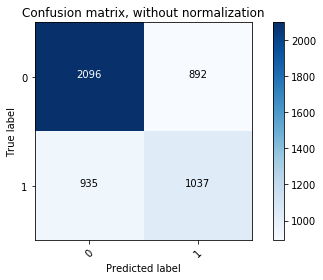

In [34]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[0.70147256 0.29852744]
 [0.47413793 0.52586207]]


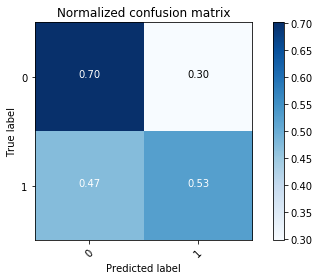

In [35]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

In [36]:
from sklearn.metrics import classification_report
print(classification_report(test[y_column], y_pred))  

             precision    recall  f1-score   support

          0       0.69      0.70      0.70      2988
          1       0.54      0.53      0.53      1972

avg / total       0.63      0.63      0.63      4960



# SVM

In [37]:
from sklearn.svm import SVC  
svclassifier = SVC(kernel='linear')  
y_pred = svclassifier.fit(train[x_columns], train[y_column]).predict(test[x_columns])  
for i in range(0,len(y_pred)):
    y_pred[i]=math.floor(y_pred[i])

C:\Users\sara\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [38]:
cnf_matrix = confusion_matrix(test[y_column]['label'], y_pred)

Confusion matrix, without normalization
[[2988    0]
 [1972    0]]


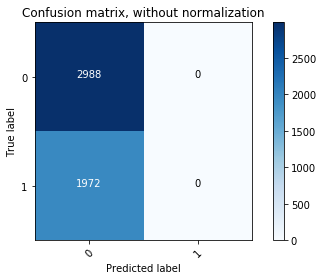

In [39]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'],
                      title='Confusion matrix, without normalization')

Normalized confusion matrix
[[1. 0.]
 [1. 0.]]


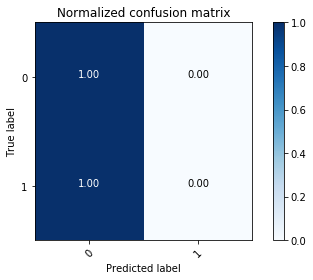

In [40]:
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0','1'], normalize=True,
                      title='Normalized confusion matrix')

In [41]:
from sklearn.metrics import classification_report
print(classification_report(test[y_column], y_pred))  

             precision    recall  f1-score   support

          0       0.60      1.00      0.75      2988
          1       0.00      0.00      0.00      1972

avg / total       0.36      0.60      0.45      4960



C:\Users\sara\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# metodi per la classificazione automatica di apnee notturne basate su un set rdotto di sensori